In [1]:
import sys; sys.path.append("..") 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model

from src.utility import *
from src.dataprocessing import *
from src import rnn

# Data

## load data

In [2]:
# Define variables
input_var   = ["FT-3061-2", "FT-3061-3", "FT-3061-4", "FT-3062-1"]
output_var  = ["TT-3061-3", "TT-3061-5", "LT-3061-2"]
process_var = input_var + output_var

In [3]:
min_len = 200
continuous_path = './data/3_continuous'

cts_list = []
i = 1
while exists(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv'):
    cts_df = loadfile(continuous_path, f"cts_{min_len}/dataset {min_len}_{i}", 'csv')
    cts_list.append(cts_df)
    i += 1

csv file is loaded from ./data/3_continuous/cts_200/dataset 200_1.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_2.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_3.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_4.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_5.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_6.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_7.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_8.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_9.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_10.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_11.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_12.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_13.csv
csv file is loaded from ./data/3_continuous/cts_200/dataset 200_14.csv
csv file is loa

## data to series

In [4]:
target_list = cts_list

history_size = 60
future_size = 20
step = 1

history_var = process_var
future_var = output_var

history_num = len(history_var)
future_num = len(future_var)

history_series = []
future_series = []

for i in range(len(target_list)):
    history, future = data2series(target_list[i], history_size, history_var, future_size, future_var,
                                  step, start_idx=0, end_idx=None)
    if not i:
        history_series = history
        future_series = future
    else:
        history_series = np.concatenate([history_series, history], axis=0)
        future_series = np.concatenate([future_series, future], axis=0)

print(history_series.shape)
print(future_series.shape)

(29365, 60, 7)
(29365, 20, 3)


## supervised attention

delta 1


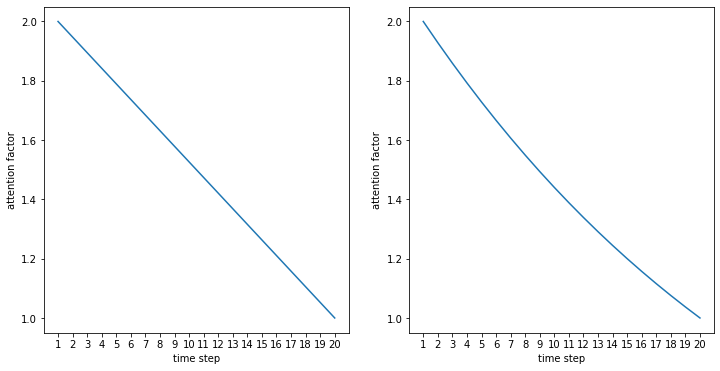

delta 5


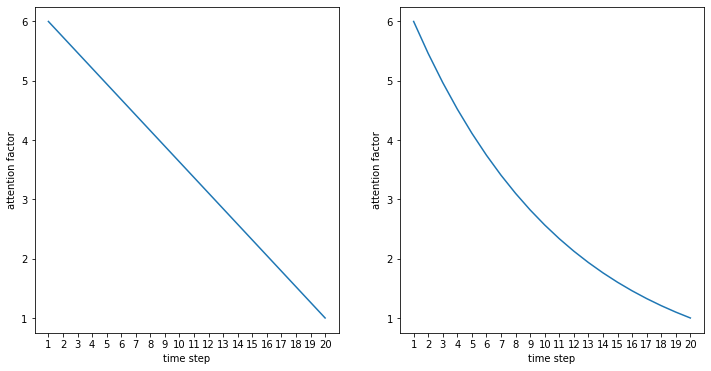

delta 10


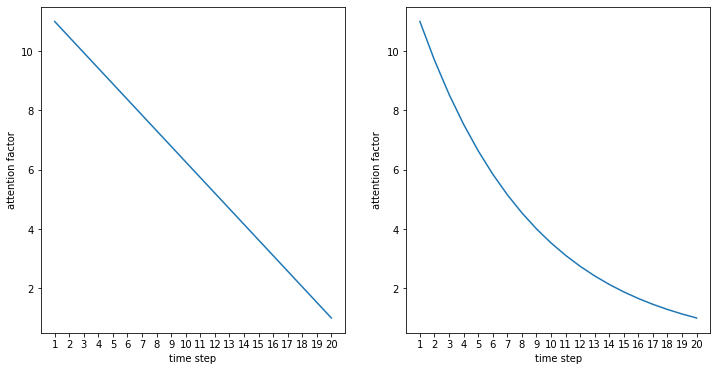

In [5]:
delta_list = [1,5,10]
for delta in delta_list:
    linear_attention = rnn.super_attention(delta, future_size, future_num, 'linear')
    exp_attention = rnn.super_attention(delta, future_size, future_num, 'exp')
    
    print(f"delta {delta}")
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot([x for x in range(1,future_size+1)], linear_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.subplot(1,2,2)
    plt.plot([x for x in range(1,future_size+1)], exp_attention[0,:,0])
    plt.xlabel("time step")
    plt.xticks([x for x in range(1,future_size+1)])
    plt.ylabel("attention factor")
    
    plt.show()

# Build model

## seq2seq model

In [6]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = seq2seq_GRU.history_test.shape[0]/seq2seq_GRU.history_train.shape[0]
seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'seq2seq_gru'
seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type)
print(seq2seq_GRU.model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 50),         8850        ['input_1[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 20, 50)       0           ['encoder[0][0]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector[0][0]',      

In [7]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    seq2seq_GRU.train()
    seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    seq2seq_GRU.model = loadfile("./model", model_name, 'model')

model is loaded from: ./model/1_50_1_50_seq2seq_gru_test


In [8]:
seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.879135,0.840094,0.86936,0.862863,6.845612,7.055288,5.560394,6.487098
1,0.793475,0.782503,0.80031,0.792096,8.788198,8.230259,6.875978,7.964812
2,0.710709,0.743171,0.701462,0.718447,9.948298,8.945895,8.408604,9.100932
3,0.6292,0.711622,0.615841,0.652221,10.887186,9.482398,9.539266,9.969617
4,0.550897,0.688427,0.570295,0.603206,11.79039,9.860371,10.089835,10.580198
5,0.477444,0.671015,0.554694,0.567718,12.675674,10.136161,10.272094,11.027976
6,0.411097,0.657645,0.547003,0.538582,13.192842,10.341489,10.361381,11.29857
7,0.353505,0.646852,0.536587,0.512315,13.558787,10.505225,10.480334,11.514782
8,0.303097,0.635792,0.520105,0.486331,13.870646,10.671088,10.664726,11.735487


## attention model

In [9]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
ATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
ATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = ATT_seq2seq_GRU.history_test.shape[0]/ATT_seq2seq_GRU.history_train.shape[0]
ATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
ATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'att_seq2seq_gru'
ATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(ATT_seq2seq_GRU.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 60, 50),     8850        ['input_2[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_1 (RepeatVector)  (None, 20, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector_1[0][0]',  

In [10]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    ATT_seq2seq_GRU.train()
    ATT_seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    ATT_seq2seq_GRU.model = loadfile("./model", model_name, 'model')

model is loaded from: ./model/1_50_1_50_att_seq2seq_gru_test


In [11]:
ATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.789045,0.82407,0.920738,0.844618,9.043903,7.400353,4.331138,6.925132
1,0.664304,0.778621,0.850329,0.764418,11.204338,8.303384,5.952845,8.486856
2,0.536731,0.729934,0.790756,0.685807,12.589195,9.173539,7.039635,9.60079
3,0.412367,0.692288,0.748568,0.617741,13.705617,9.795124,7.717376,10.406039
4,0.300114,0.662281,0.718498,0.560298,14.71868,10.265756,8.166565,11.050334
5,0.201549,0.639627,0.694054,0.511743,15.668553,10.608684,8.514365,11.597201
6,0.113042,0.622626,0.67314,0.469603,16.190794,10.857513,8.801382,11.949896
7,0.034132,0.60945,0.654076,0.432553,16.572854,11.047531,9.054851,12.225079
8,-0.034426,0.598626,0.632964,0.399055,16.89897,11.202333,9.326756,12.47602


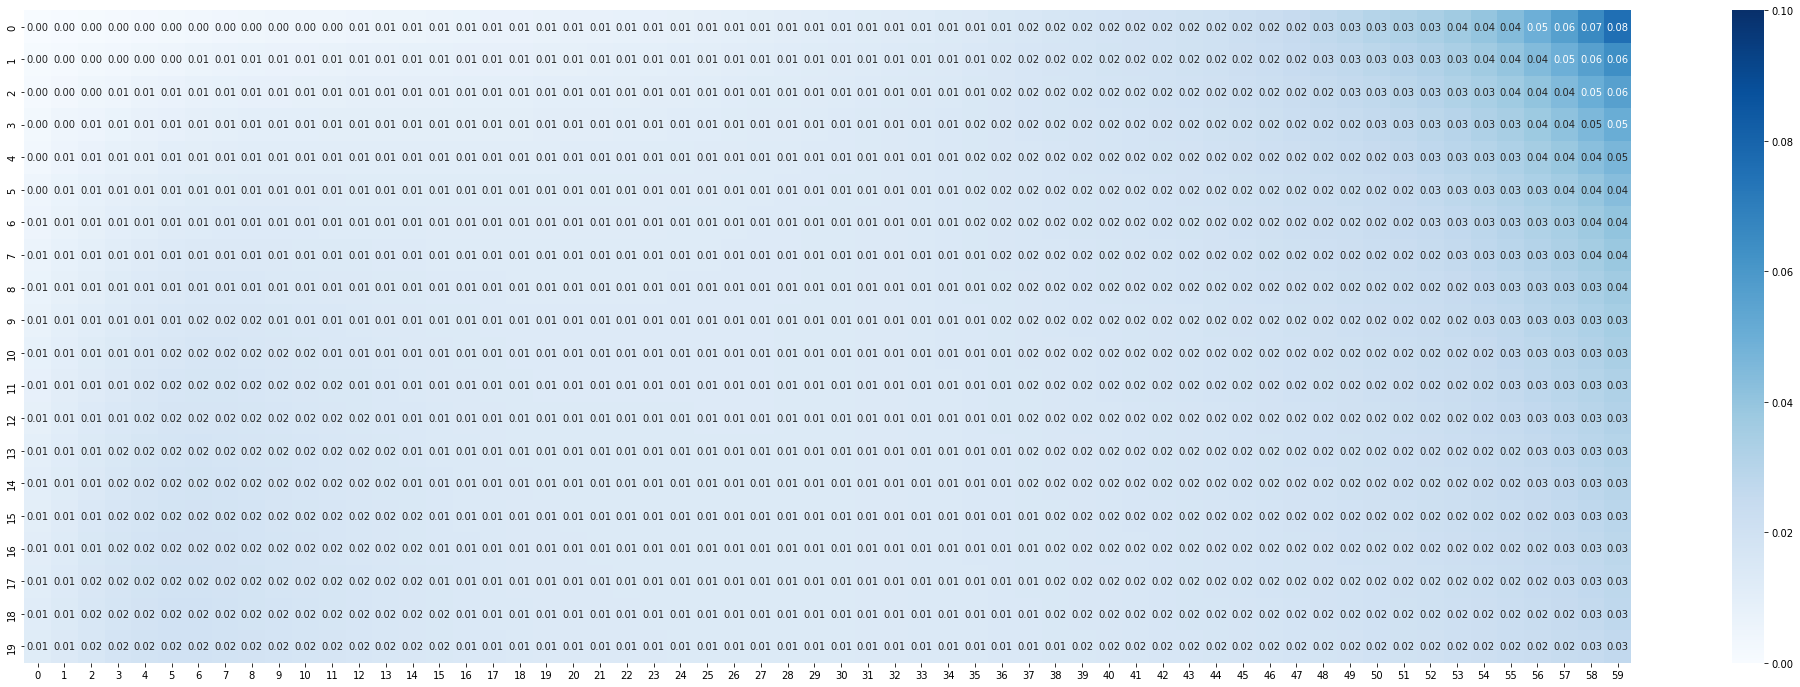

In [12]:
attention = ATT_seq2seq_GRU.get_attention(ATT_seq2seq_GRU.history_test_sc)
attention_mean = attention.mean(axis=0)
attention_std = attention.std(axis=0)

plt.figure(figsize=(36,12))
ax = sns.heatmap(attention_mean, cmap='Blues', vmin=0, vmax=0.1, annot=True, fmt='.2f')

## dual attention model

In [13]:
# supervised attention factor 생성
delta = 1
att_type = 'linear'
factor = rnn.super_attention(delta, future_size, future_num, att_type)

# RNN class 생성
DATT_seq2seq_GRU = rnn.RNN(history_series, history_var, future_series, future_var)

# 테스트 데이터 스플릿
test_size = 0.2
test_num = -1
DATT_seq2seq_GRU.train_test(test_size=test_size, test_num=test_num)

# 검증 데이터 스플릿
valid_size = DATT_seq2seq_GRU.history_test.shape[0]/DATT_seq2seq_GRU.history_train.shape[0]
DATT_seq2seq_GRU.train_valid(valid_size=valid_size)

# 데이터 스케일링
DATT_seq2seq_GRU.scaling()

# 모델 구성
num_layers = 1
num_neurons = 50
dense_layers = 1
dense_neurons = 50
model_type = 'datt_seq2seq_gru'
DATT_seq2seq_GRU.build_model(num_layers=num_layers, num_neurons=num_neurons, dense_layers=dense_layers, dense_neurons=dense_neurons, model_type=model_type, factor=factor)
print(DATT_seq2seq_GRU.model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 encoder (GRU)                  [(None, 60, 50),     8850        ['input_3[0][0]']                
                                 (None, 50)]                                                      
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 20, 50)      0           ['encoder[0][1]']                
                                                                                                  
 decoder (GRU)                  (None, 20, 50)       15300       ['repeat_vector_2[0][0]',  

In [14]:
model_num = 'test'
model_name = f"{num_layers}_{num_neurons}_{dense_layers}_{dense_neurons}_{model_type}_{model_num}"

if not exists("./model", model_name, 'model'):
    DATT_seq2seq_GRU.train()
    DATT_seq2seq_GRU.save_model(f"./model/{model_name}")
else:
    DATT_seq2seq_GRU.model = loadfile("./model", model_name, 'model')

model is loaded from: ./model/1_50_1_50_datt_seq2seq_gru_test


In [15]:
DATT_seq2seq_GRU.test()

,TT-3061-3,TT-3061-5,LT-3061-2,mean,TT-3061-3,TT-3061-5,LT-3061-2,mean
index,R2,R2,R2,R2,nRMSE,nRMSE,nRMSE,nRMSE
0,0.872082,0.878842,0.918002,0.889642,7.042501,6.141259,4.405256,5.863005
1,0.795011,0.80551,0.869383,0.823301,8.755447,7.782797,5.56104,7.366428
2,0.692965,0.745822,0.835412,0.758067,10.248843,8.8996,6.24342,8.463954
3,0.567596,0.708755,0.812751,0.696368,11.756832,9.529422,6.659918,9.31539
4,0.434884,0.683414,0.798259,0.638852,13.225869,9.939373,6.913464,10.026235
5,0.298859,0.664946,0.786619,0.583475,14.682752,10.229219,7.110628,10.6742
6,0.171559,0.651342,0.775521,0.532808,15.647581,10.436239,7.29387,11.125897
7,0.061398,0.63985,0.761959,0.487735,16.33726,10.60886,7.511341,11.48582
8,-0.035736,0.628726,0.741432,0.444807,16.909668,10.774108,7.828242,11.837339


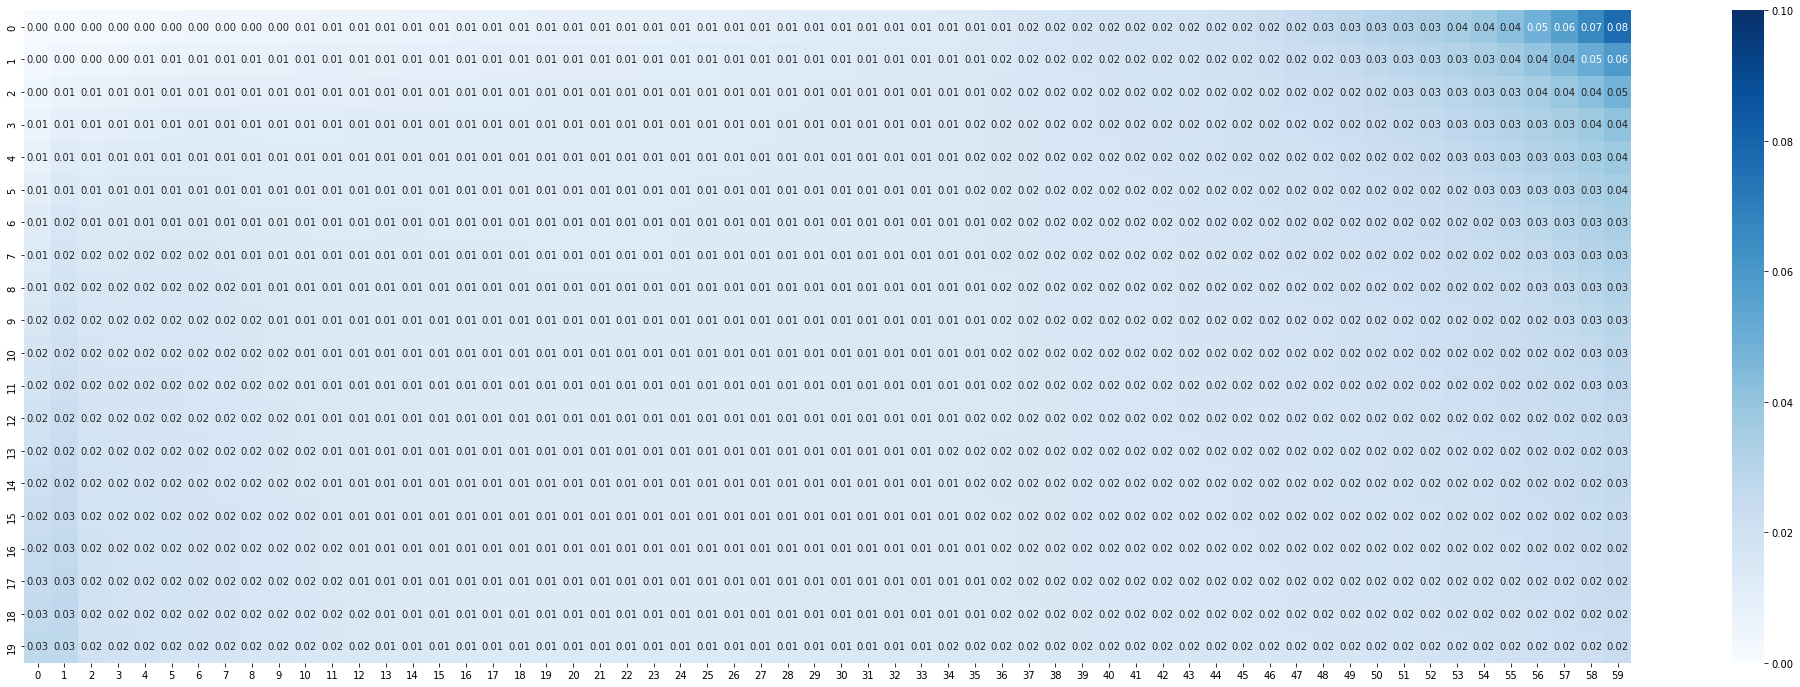

In [16]:
attention = DATT_seq2seq_GRU.get_attention(DATT_seq2seq_GRU.history_test_sc)
attention_mean = attention.mean(axis=0)
attention_std = attention.std(axis=0)

plt.figure(figsize=(36,12))
ax = sns.heatmap(attention_mean, cmap='Blues', vmin=0, vmax=0.1, annot=True, fmt='.2f')